This is my submission for [STUOD's Hackathon.](https://www.imperial.ac.uk/news/219153/stuods-hackathon-winners-announced/)

In this hackathon, we decided to predict a variety of things about cyclones using previous data.

The data was sparse and fairly discrete, in which case neural networks didn't do as well as decision trees. For this reason, a focus on decision trees was made.

The data was in the form of tables of tables. Each table recorded information about a specific cyclone, and, there were several thousand of such tables.

The pipeline used was as follows:

1) Load in the data, and do very basic data cleaning.

2) Train on the data using a decision tree

3) Look for funny predicitions and use the decision tree or random forests to further clean the data by either removing redundant

4) Predict using random forests trained on this cleaned data.

5) Create a tool to automatically do steps 1-4, and predict anything we want about the cyclone.

To do the last part, many self-made functions had to be made.

Once this was done, the code was cleaned so that we can just load in the data, and use the `do_it_all` function

The deployement of such a tool in practice is perhaps not something that should be do as of yet. Having a human in the equation as a circuit breaker to make sure unknown biases aren't introduced is key. In this example positive feedback loops aren't something to worry about, especially in the context of cyclones!

The last part of this code is on data visualisation; my favourite plots to use with decision trees are waterfall and partial dependence plots. The partial dependence plots and feature significance determined by the model matched the intuition of leading atmospheric scientists.

#### Connect to gdrive and fast gpu

In [2]:
!nvidia-smi

Thu Jun  3 11:20:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

#### Load in small cyclone data, and heavy cleaning
Save as storms (where storms[stormid] is a dataframe)

In [4]:
# the dataset can be downloaded here: https://github.com/sotakao/STUOD_Hackathon_2021/tree/main/datasets/tropical_cyclones

In [ ]:
import pandas as pd
import os
# directory = "/content/gdrive/MyDrive/stuod/tropical_cyclones/data/"
# directory = "/Users/dk/project/stuod/tropical_cyclones/data/"
names = ['BASIN', 'CY', 'date', 'TECHNUM/MIN', 'TECH', 'TAU', 'LatN/S', 'LonE/W', 'VMAX', 'MSLP', 'TY', 'RAD', 'WINDCODE', 'RAD1', 'RAD2', 'RAD3', 'RAD4', 'POUTER', 'ROUTER', 'RMW', 'GUSTS', 'EYE', 'SUBREGION', 'MAXSEAS', 'INITIALS', 'DIR', 'SPEED', 'STORMNAME', 'DEPTH', 'SEAS', 'SEASCODE', 'SEAS1', 'SEAS2', 'SEAS3', 'SEAS4', 'USERDEFINED1', 'userdata1', 'USERDEFINED2', 'userdata2', 'USERDEFINED3', 'userdata3', 'USERDEFINED4', 'userdata4', 'USERDEFINED5', 'userdata5']
storms = {}
for filename in os.listdir(directory):
    stormid = filename[:9]
    storms[stormid] = pd.read_table(directory+filename, sep = ',', names = names)

In [ ]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', None)

In [ ]:
# drop user_defined columns for all observations
cols_to_drop = names[-10:] + ['STORMNAME', 'TECH', 'TAU', 'MAXSEAS', 'TECHNUM/MIN', 'INITIALS', 'DIR', 'SPEED'] 

for filename in os.listdir(directory):
    stormid = filename[:9]
    storms[stormid] = storms[stormid].drop(cols_to_drop, axis=1)

In [ ]:
# !!! we further remove BASIN and SUBREGION information, relying only on the LAT/LONG data, although
# this can be undone if we want later

further_drops = ['BASIN', 'SUBREGION']

for filename in os.listdir(directory):
    stormid = filename[:9]
    storms[stormid] = storms[stormid].drop(further_drops, axis=1)

# (optional)
# we may also remove the 'test storms' or invests in CY

In [ ]:
# we need to convert latitude and longitude data to numeric data as so:
# 104N -> 104 , 92S -> -93
# 1500W -> -1500, 1200E -> 1200
# this is very crucial, so I hope it's correct

for filename in os.listdir(directory):
    stormid = filename[:9]
    for i in range(len(storms[stormid])):
        temp_lat = storms[stormid]['LatN/S'][i]
        temp_lon = storms[stormid]['LonE/W'][i]

        if not isinstance(temp_lat, float):
            if temp_lat[-1] == 'N':
                storms[stormid].at[i, 'LatN/S'] = float(temp_lat[:-1])
            elif temp_lat[-1] == 'S':
                storms[stormid].at[i, 'LatN/S'] = -1*float(temp_lat[:-1])
        
        if not isinstance(temp_lon, float):
            if temp_lon[-1] == 'E':
                storms[stormid].at[i, 'LonE/W'] = float(temp_lon.strip()[:-1])
            elif temp_lon[-1] == 'W':
                storms[stormid].at[i, 'LonE/W'] = -1*float(temp_lon.strip()[:-1])

# check
print('success!')
storms[stormid]

success!


,CY,date,LatN/S,LonE/W,VMAX,MSLP,TY,RAD,WINDCODE,RAD1,RAD2,RAD3,RAD4,POUTER,ROUTER,RMW,GUSTS,EYE,DEPTH,SEAS,SEASCODE,SEAS1,SEAS2,SEAS3,SEAS4
0,95,2014102618,140,-520,20,1012,DB,0,,0,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95,2014102700,145,-535,20,1011,DB,0,,0,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,95,2014102706,150,-546,25,1010,DB,0,,0,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,95,2014102712,155,-555,25,1010,DB,0,,0,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,95,2014102718,160,-564,25,1010,DB,0,,0,0,0,0,1013,200.0,70.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,95,2014102918,192,-629,30,1009,LO,0,,0,0,0,0,1011,150.0,100.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN
13,95,2014103000,193,-635,30,1009,LO,0,,0,0,0,0,1011,150.0,100.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN
14,95,2014103006,194,-640,30,1008,LO,0,,0,0,0,0,1009,120.0,100.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN
15,95,2014103012,197,-645,30,1008,LO,0,,0,0,0,0,1009,120.0,100.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN


In [ ]:
# next steps is to make the dataframe messier again by changing the YYMMDDHH to have some metadata info
# note, my below implementation can be 3x faster, however for debugging reasons I don't do this
# 1) change format to appropriate string format
# 2) convert string format to timedate type
# 3) add column metadata
# 4) remove unnecessary columns
from fastai.tabular.all import *
for filename in os.listdir(directory):
    
    stormid = filename[:9]
    testHour_series = pd.Series([], dtype=int)
    
    storms[stormid]['date']=storms[stormid]['date'].astype(str, copy=True)
    for i in range(len(storms[stormid])):
        # eg: converts 2015041500 (str) -> 2015-04-15-00 (string)
        x = storms[stormid]['date'][i].strip()
        if len(x) == 0: 
            storms[stormid].at[i, 'date'] = np.nan
            testHour_series = testHour_series.append(pd.Series([np.nan]), ignore_index=True)
            continue
        storms[stormid].at[i, 'date'] = x[:4]+'-'+x[4:6]+'-'+x[6:8]
        testHour_series = testHour_series.append(pd.Series([int(x[8:])]), ignore_index=True)
    
    # eg: converts 2015-04-15-00 (string) -> time of type np.dtype('datetime64[ns]')
    make_date(storms[stormid], 'date')
    
    # add column metadata (we hope the hours do not freak it out!)
    storms[stormid] = add_datepart(storms[stormid], 'date')
    storms[stormid] = storms[stormid].assign(testHour=testHour_series.values)

     # remove unnecessary columns
    drop_unes = ['Dayofweek', 'Is_month_start', 'Is_month_end', 
                 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 
                 'Is_year_end', 'Is_year_start', 'Month', 'Day']
    storms[stormid] = storms[stormid].drop(drop_unes, axis=1)
    
    # fix elapsed rounding errors
    storms[stormid]['Elapsed'] = storms[stormid]['Elapsed'] + storms[stormid]['testHour']*3600

# check
print('success!')
storms[stormid]

success!


,CY,LatN/S,LonE/W,VMAX,MSLP,TY,RAD,WINDCODE,RAD1,RAD2,RAD3,RAD4,POUTER,ROUTER,RMW,GUSTS,EYE,DEPTH,SEAS,SEASCODE,SEAS1,SEAS2,SEAS3,SEAS4,Year,Week,Dayofyear,Elapsed,testHour
0,95,140,-520,20,1012,DB,0,,0,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,43,299,1.414346e+09,18
1,95,145,-535,20,1011,DB,0,,0,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,44,300,1.414368e+09,0
2,95,150,-546,25,1010,DB,0,,0,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,44,300,1.414390e+09,6
3,95,155,-555,25,1010,DB,0,,0,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,44,300,1.414411e+09,12
4,95,160,-564,25,1010,DB,0,,0,0,0,0,1013,200.0,70.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN,2014,44,300,1.414433e+09,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,95,192,-629,30,1009,LO,0,,0,0,0,0,1011,150.0,100.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN,2014,44,302,1.414606e+09,18
13,95,193,-635,30,1009,LO,0,,0,0,0,0,1011,150.0,100.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN,2014,44,303,1.414627e+09,0
14,95,194,-640,30,1008,LO,0,,0,0,0,0,1009,120.0,100.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN,2014,44,303,1.414649e+09,6
15,95,197,-645,30,1008,LO,0,,0,0,0,0,1009,120.0,100.0,0.0,0.0,S,,NaN,NaN,NaN,NaN,NaN,2014,44,303,1.414670e+09,12


We're done with data cleaning (for now), next we save, and continue with doing actual ML!!!

#### Fast Tabs
self-made API to create models on dep_vars, with varying strategies on the fly

In [ ]:
from fastbook import *
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
np.random.seed(42)

In [ ]:
### IMPORTANT FUNCTIONS

def make_train_valid(which_table):
  xs,y = which_table.train.xs,which_table.train.y
  valid_xs,valid_y = which_table.valid.xs,which_table.valid.y
  return xs, y, valid_xs, valid_y


def rf(xs, y, n_estimators=40, max_samples=20000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

def rf_feat_importance(m, xs):
    return pd.DataFrame({'cols':xs.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)


def remove_useless_features(fi, xs, valid_xs, threshold=0.005):
  to_keep = fi[fi.imp>threshold].cols
  xs_final = xs[to_keep]
  valid_xs_final = valid_xs[to_keep]
  return xs_final, valid_xs_final

In [ ]:
### TRAIN RANDOM FOREST ON DEPENDANT VARIABLE, REMOVING INSIGNIFICANT COLUMNS

def fast_rf(dependant_var, tensor_table, threshold=0.005, returns=False):
    xs, y, valid_xs, valid_y = make_train_valid(tensor_table[dependant_var])
    m = rf(xs=xs, y=y)
    feats = rf_feat_importance(m, xs)
    xs_final, valid_xs_final = remove_useless_features(feats, xs, valid_xs, threshold=threshold)
    m_final = rf(xs_final, y)
    feats_final = rf_feat_importance(m_final, xs_final)
  
    if returns:
      return (m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final)

In [ ]:
from itertools import chain
from io import StringIO
from csv import writer

In [ ]:
### IMPORTANT FUNCTIONS

def make_columns(SLIDING_WINDOW, TIME_STEPS, pred_cols):
    cols = []
    cur_cols = list(storms[stormid].columns)
    n = len(cur_cols)
    
    #training cols
    for i in range(SLIDING_WINDOW):
        for j in range(n):
            if cur_cols[j] == 'CY' and j > 0:
                continue
            cols.append(cur_cols[j] + str(i))
    
    #predict cols
    for i in range(TIME_STEPS):
        for j in range(len(pred_cols)):
            cols.append(pred_cols[j] + str(i + SLIDING_WINDOW))
    
    return cols


def write_to_csv(SLIDING_WINDOW, TIME_STEPS, pred_cols, csv_name, super_cols):
  output = StringIO()
  csv_writer = writer(output)
  for filename in os.listdir(directory):
      stormid = filename[:9]
      n = len(storms[stormid])
      
      for shift in range(n-(SLIDING_WINDOW+TIME_STEPS)+1):
          x = []
          for i in range(shift, shift+SLIDING_WINDOW):
              x.append(list(storms[stormid].loc[i]))
          
          const_vals = []
          for i in range(shift+SLIDING_WINDOW, shift+SLIDING_WINDOW*2):
              for j in pred_cols:
                const_vals.append(storms[stormid][j][i])

          x.append(const_vals)
          x = list(chain.from_iterable(x))
          csv_writer.writerow(x)
  output.seek(0)
  df = pd.read_csv(output, names = super_cols)
  df.to_csv(csv_name, index=False)
  print('success!')

In [ ]:
### THE SUPER FUNCTION

def super_rf(SLIDING_WINDOW, TIME_STEPS, pred_cols, csv_name):
  '''
  Input:
  SLIDING_WINDOW, TIME_STEPS : int > 0
  pred_cols : list of columns to predict, must be found in storms[stormid]
  csv_name : name of csv (string or path) to save specific cleaned data

  Output:
  models_list_name list containing:
  TIME_STEPS*len(pred_cols) optimised random forest models
  with respective parameters:
    m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final

  Each rf predicts pred_cols values, TIME_STEPS in advance, using a
  sliding_window data-extraction look-ahead technique.
  '''

  super_cols = make_columns(SLIDING_WINDOW, TIME_STEPS, pred_cols)
  write_to_csv(SLIDING_WINDOW, TIME_STEPS, pred_cols, csv_name, super_cols)
  df = pd.read_csv(csv_name, low_memory=False)
  df = df.fillna(0)


  # ADD ORDERED CATEGORICAL VARIABLES HERE
  depths = ['S', 'M', 'D']
  for i in range(TIME_STEPS):
    df['DEPTH' + str(i)] = df['DEPTH' + str(i)].astype('category')
    df['DEPTH' + str(i)].cat.set_categories(depths, ordered=True, inplace=True)

  # DEPENDANT VARIABLES
  dep_vars = list(df.columns[-1*TIME_STEPS*len(pred_cols):])

  # FINAL TABLE CLEANING
  procs = [Categorify, FillMissing, Normalize]
  cont,cat = cont_cat_split(df)
  for i in dep_vars:
    if i in cont:
      cont.remove(i)
    else:
      cat.remove(i)

  # TRAIN, VALID DATASET SPLIT
  cond = (df.Year0<2018)
  train_idx = np.where( cond)[0]
  valid_idx = np.where(~cond)[0]
  splits = (list(train_idx),list(valid_idx))
  
  ### GENERATE TABLES FOR EACH DEPENDANT VARIABLE
  # to access relevant table, do: tensor_table['required_dependant']

  keys = dep_vars
  tensor_table = {key: None for key in keys}

  for i in dep_vars:
    tensor_table[i] = TabularPandas(df, procs, cat, cont, 
                                    y_names=i, splits=splits)

  for i in dep_vars:
      m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = fast_rf(i, tensor_table, returns=True)
      models_list_name.append([m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final])

  # output is models_list_name list containing respective model
  print('success!')

### Usage

In [ ]:
# To use the above code, we need to define several parameters
# SLIDING_WINDOW and TIME_STEPS tell us how far back in the past and how far forward into the future we want to predict
# pred_cols is the thing we want to predict
# csv_name is the csv we use to train on
# models_list_name creates a list of models, keep as empty

SLIDING_WINDOW = 3
TIME_STEPS = 3
pred_cols = ['TY']
csv_name = 'cleaned_example.csv'
models_list_name = []

super_rf(SLIDING_WINDOW, TIME_STEPS, pred_cols, csv_name)

#### This is what was used to predict certain cyclone ascepts for competition submission and discussion

In [ ]:
SLIDING_WINDOW = 3
TIME_STEPS = 3
models_list_name = []

In [ ]:
# EYE DIAMETER ; eye diameter, 0 - 120 n mi.
pred_cols = ['EYE']
csv_name = 'cleaned_eye.csv'
super_rf(SLIDING_WINDOW, TIME_STEPS, pred_cols, csv_name)

success!
success!


In [ ]:
# LOCATIONS 0 <= Lat <= 900  N/S, in tenths of degrees ; 0 <= Lon <=1800  E/W, in tenths of degrees
pred_cols = ['LatN/S', 'LonE/W']
csv_name = 'cleaned_locs.csv'
super_rf(SLIDING_WINDOW, TIME_STEPS, pred_cols, csv_name)

success!
success!


In [ ]:
# VMAX : Maximum sustained wind speed in knots: 0 - 300 kts
pred_cols = ['VMAX']
csv_name = 'cleaned_vmax.csv'
super_rf(SLIDING_WINDOW, TIME_STEPS, pred_cols, csv_name)

success!
success!


### Evaluation
We use sklearn's model evaluations and metrics

In [ ]:
# !!! FIX TO ALLOW FOR EITHER CLASSIFICATION OR REGRESSION METRICS

# METRICS FUNCTIONS

import sklearn.metrics as sm

# possible metrics:
pos_mets = [
            # 'sm.explained_variance_score(y_pred, y)',
                # 'sm.max_error(y_pred, y)',
                # 'sm.mean_absolute_error(y_pred, y)',
                'sm.mean_squared_error(y_pred, y)',
                # 'sm.mean_squared_log_error(y_pred, y)', our thing has neg values, so this won't work
                # 'sm.median_absolute_error(y_pred, y)',
                # 'sm.mean_absolute_percentage_error(y_pred, y)', this doesn't work on my python
                'sm.r2_score(y_pred, y)',
                # 'sm.mean_poisson_deviance(y_pred, y)',
                # 'sm.mean_gamma_deviance(y_pred, y)',
                # 'sm.mean_tweedie_deviance(y_pred, y)' # this won't work due to neg vals
                ]

def print_all_metrics(y_pred, y, y_pred_valid, y_valid):
  for met in pos_mets:
      print(str(met)[3:-11], ' training_preds: ', eval(met),
            ' validation_preds: ',
            eval(met[:-11]+'(y_pred_valid, y_valid)'))

# eg: print_all_metrics(m_final.predict(xs_final), y, m_final.predict(valid_xs_final), valid_y)

#### USAGE

In [ ]:
# models_list_name order : eye (3), locs(6), rad(3), ty(3), vmax(3)
# models_list_name = 3 or 6 long; 3 if not locations
# out_info[0]: m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final

In [ ]:
# EYE 1 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[0]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

mean_squared_error  training_preds:  7.632527233967932  validation_preds:  11.217976292245158
r2_score  training_preds:  0.8383155099132356  validation_preds:  0.8414449749408434


In [ ]:
# EYE 2 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[1]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

mean_squared_error  training_preds:  7.465922673041497  validation_preds:  25.923305071643615
r2_score  training_preds:  0.8241839682359026  validation_preds:  0.489900030638621


In [ ]:
# EYE 3 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[2]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

mean_squared_error  training_preds:  7.332340831662941  validation_preds:  33.444720910872334
r2_score  training_preds:  0.8158272170784098  validation_preds:  0.24967018048355738


In [ ]:
# LOC 1 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[3]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

# LOC 2 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[4]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

# LOC 3 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[5]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

# LOC 4 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[6]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

# LOC 5 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[7]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

# LOC 6 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[8]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

mean_squared_error  training_preds:  10.48257539084539  validation_preds:  21.25340734785797
r2_score  training_preds:  0.9996018135972506  validation_preds:  0.9993350319254808
mean_squared_error  training_preds:  4114.208901869144  validation_preds:  6821.227841466671
r2_score  training_preds:  0.9969546776292868  validation_preds:  0.9947586998298086
mean_squared_error  training_preds:  22.824832358903578  validation_preds:  45.293239799746715
r2_score  training_preds:  0.9991562478655436  validation_preds:  0.9986212540548651
mean_squared_error  training_preds:  5126.212350067168  validation_preds:  11636.043161886548
r2_score  training_preds:  0.9962030368455278  validation_preds:  0.9910470079210684
mean_squared_error  training_preds:  38.02013182778786  validation_preds:  80.67365143105258
r2_score  training_preds:  0.9986335541445367  validation_preds:  0.9976130592832464
mean_squared_error  training_preds:  7026.36079748293  validation_preds:  14532.20130582873
r2_score  train

In [ ]:
# VMAX 1 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[9]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

print()
# VMAX 2 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[10]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

print()
# VMAX 3 timestep metrics
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[11]

print_all_metrics(m_final.predict(xs_final), y, 
                  m_final.predict(valid_xs_final), valid_y)

mean_squared_error  training_preds:  14.81706052022509  validation_preds:  17.924207937731424
r2_score  training_preds:  0.9857156266443273  validation_preds:  0.9835935028657904

mean_squared_error  training_preds:  31.7684443957606  validation_preds:  34.653979384106684
r2_score  training_preds:  0.9684135842772185  validation_preds:  0.9671329317408102

mean_squared_error  training_preds:  47.59542127649379  validation_preds:  55.69046997648155
r2_score  training_preds:  0.9513232451093865  validation_preds:  0.9457450092194004


### Model Visualisations
Visualisations for our random forests, feature importances, partial dependencies

In [ ]:
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeRegressor

In [ ]:
def view_tree_simple(xs, y, max_leaf_nodes=4, size=10):
  m = DecisionTreeRegressor(max_leaf_nodes)
  m.fit(xs, y)
  draw_tree(m, xs, size=size, leaves_parallel=True, precision=2)

def view_visual_simple(xs, y, dep_var, max_leaf_nodes=4):
  m = DecisionTreeRegressor(max_leaf_nodes)
  m.fit(xs, y)
  samp_idx = np.random.permutation(len(y))[:500]
  dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
          fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
          orientation='LR')

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [ ]:
# PREDICTING EYE

Below we see how one of the decision trees predicts a cyclone's characteristics using various parameters

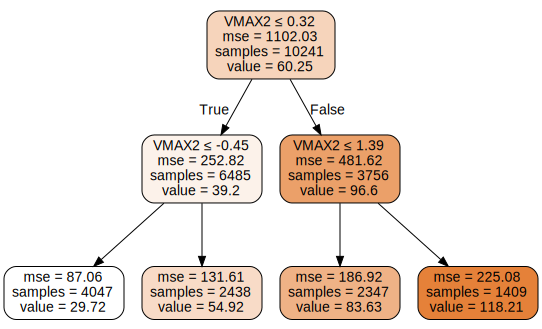

In [ ]:
xs, y = models_list_name[11][3], models_list_name[11][4]

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

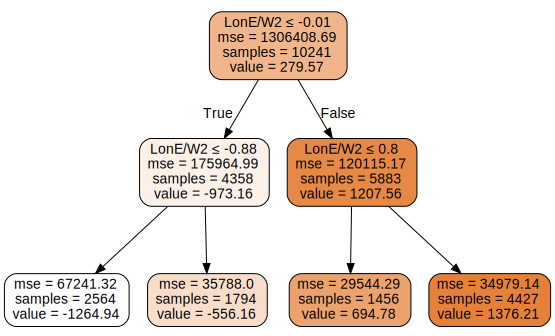

In [ ]:
xs, y = models_list_name[4][3], models_list_name[4][4]

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

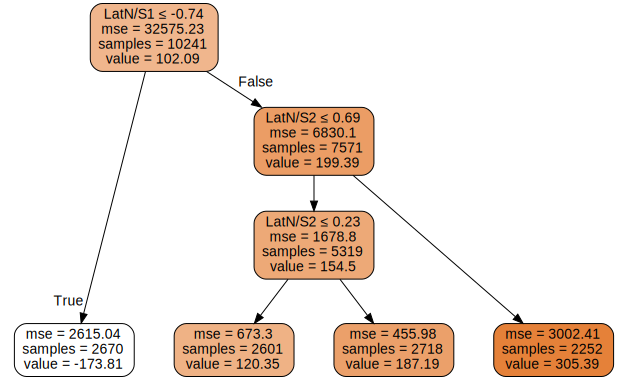

In [ ]:
xs, y = models_list_name[5][3], models_list_name[5][4]

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

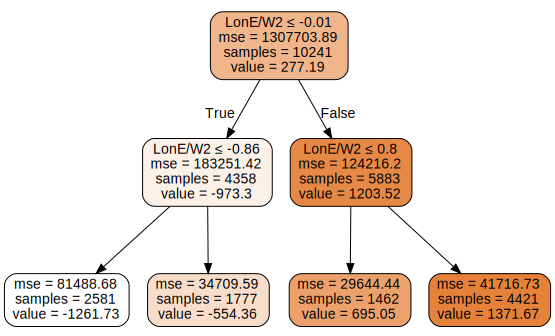

In [ ]:
xs, y = models_list_name[6][3], models_list_name[6][4]

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

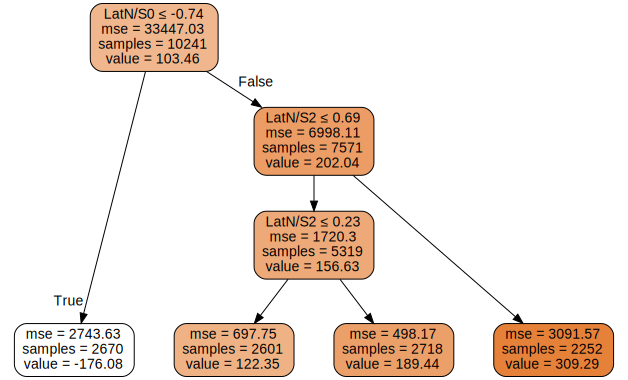

In [ ]:
xs, y = models_list_name[7][3], models_list_name[7][4]

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

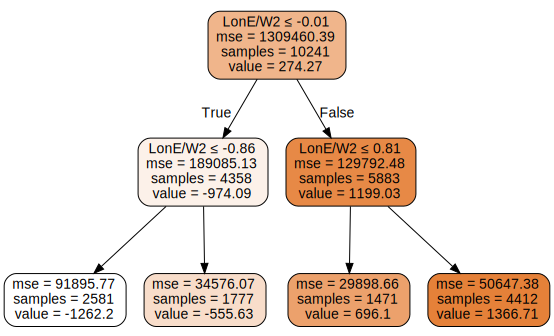

In [ ]:
xs, y = models_list_name[8][3], models_list_name[8][4]

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

The below I use to determine if any of the data is strange and should be cleaned.

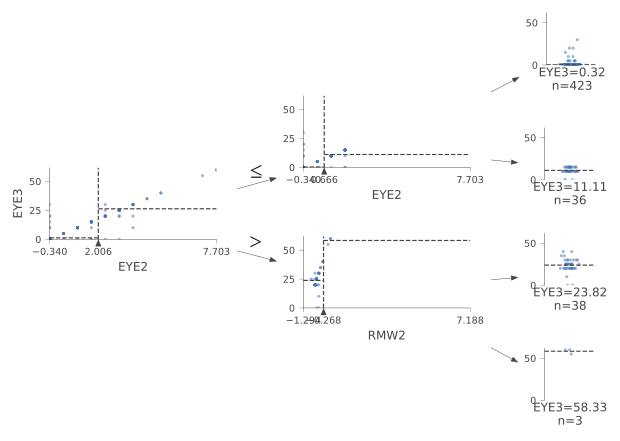

In [ ]:
xs, y = models_list_name[9][3], models_list_name[9][4]
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, 'EYE3',
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

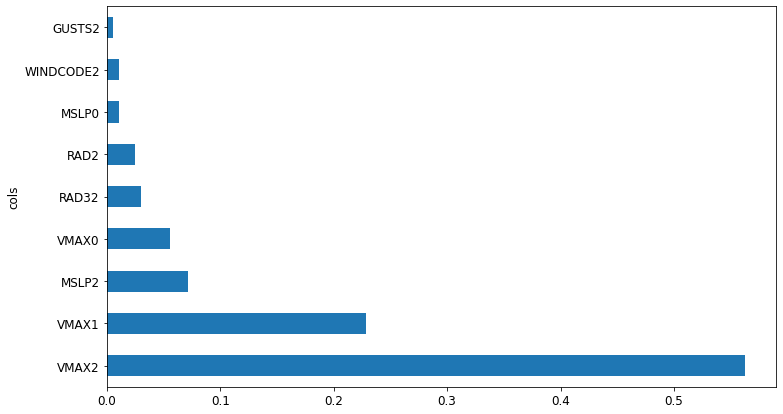

In [ ]:
# feature importances
# models_list_name order : eye (3), locs(6), rad(3), ty(3), vmax(3)
# models_list_name = 3 or 6 long; 3 if not locations
# out_info[0]: m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final

plot_fi(models_list_name[11][6]);

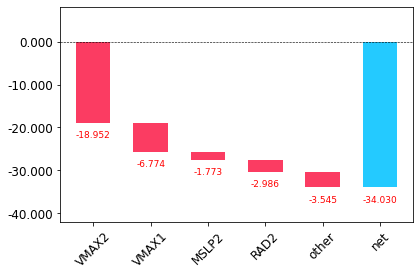

In [ ]:
# waterfall plots

import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[11]

row = valid_xs_final.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_final, row.values)
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

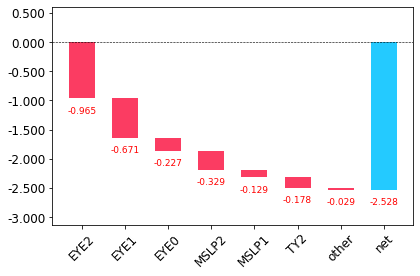

In [ ]:
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[1]

row = valid_xs_final.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_final, row.values)
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

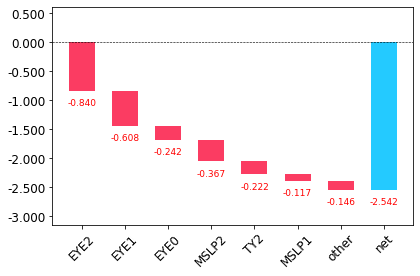

In [ ]:
m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[2]

row = valid_xs_final.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_final, row.values)
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

In [ ]:
list(valid_xs_final.columns)

Index(['LatN/S2', 'LatN/S0', 'LatN/S1', 'Week0', 'Week2', 'Dayofyear2'], dtype='object')

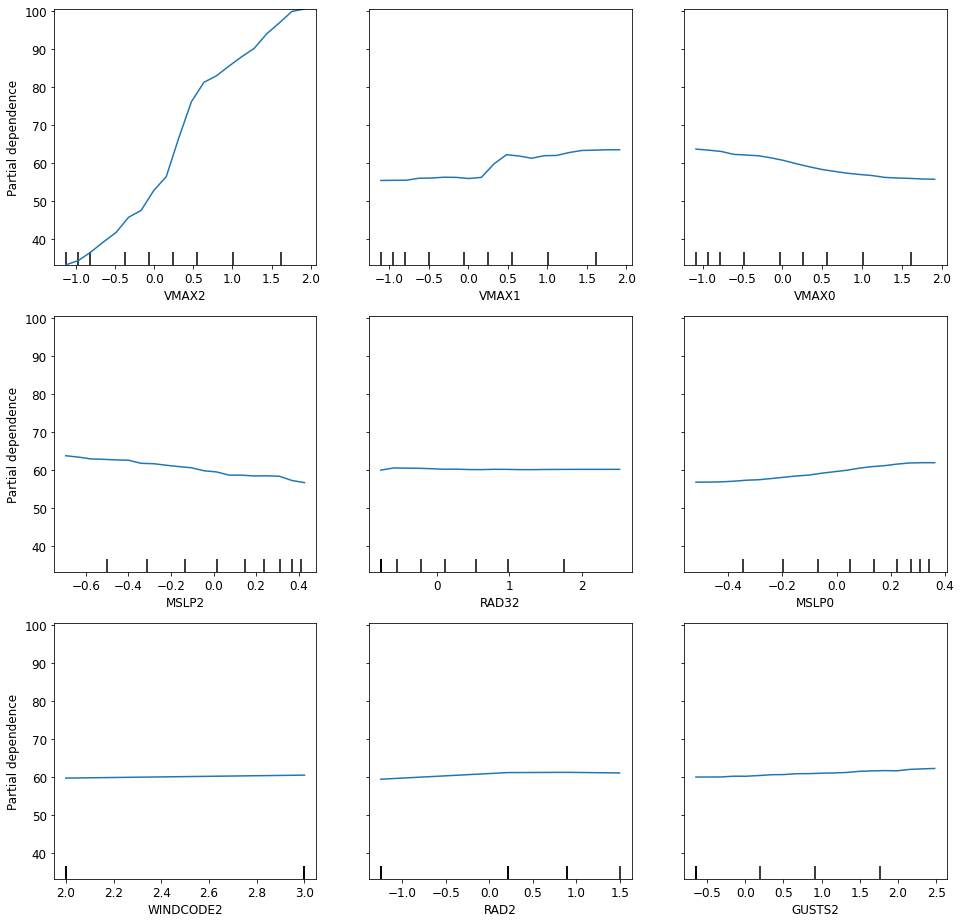

In [ ]:
# partial dependance
from sklearn.inspection import plot_partial_dependence


m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final = models_list_name[11]

fig,ax = plt.subplots(figsize=(16, 16))
plot_partial_dependence(m_final, valid_xs_final, list(valid_xs_final.columns),
                        grid_resolution=20, ax=ax);

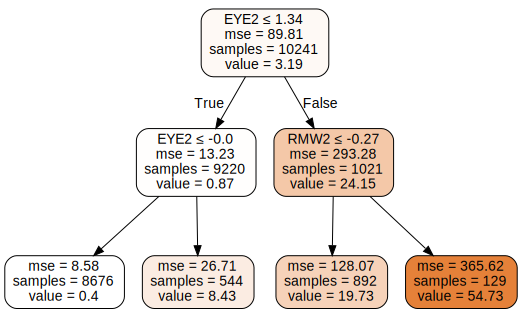

In [ ]:
xs, y = models_list_name[1][3], models_list_name[1][4]

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

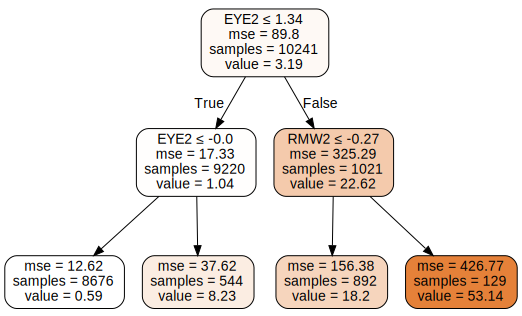

In [ ]:
xs, y = models_list_name[2][3], models_list_name[2][4]

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [ ]:
view_tree_simple()

In [ ]:
# models_list_name order : eye (3), locs(6), rad(3), ty(3), vmax(3)
# models_list_name = 3 or 6 long; 3 if not locations
# models_list_name[0]: m_final, xs_final, y, valid_xs_final, valid_y, feats, feats_final

### Final remarks and TODO


I would like to be able to plot our predictions of cyclone trajectories and features in contrast to the actual info on a map.
